<a href="https://colab.research.google.com/github/gryffin31/Deep-Learning-Edvancer/blob/main/Aishwarya_Pattnaik_P3_Spam%20filter%20for%20Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [ ]:
!unzip '/content/drive/My Drive/P3_Spam filter for Quora Questions Page/P3 Quora Text Classification with embeddings.zip'

Archive:  /content/drive/My Drive/P3_Spam filter for Quora Questions Page/P3 Quora Text Classification with embeddings.zip
mapname:  conversion of  failed
 extracting: train.csv               


In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
df.shape

(1306122, 3)

In [ ]:
cols = df.columns
for col in cols:
  print('Number of unique values:', df[col].nunique())

Number of unique values: 1306122
Number of unique values: 1306122
Number of unique values: 2


In [ ]:
# Download the glove embedding

!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-07-18 13:24:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-18 13:24:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-18 13:24:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
all_ques=" ".join(df['question_text'])
nspam_ques=" ".join(df.loc[df['target']==0,"question_text"])
spam_ques=" ".join(df.loc[df['target']==1,"question_text"])

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

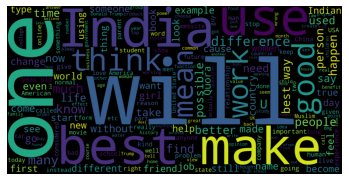

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', 
                      width=4000,height=2000).generate(all_ques)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

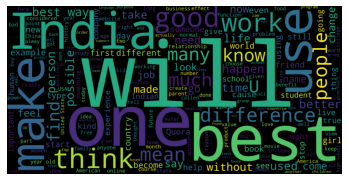

In [ ]:
wordcloud1 = WordCloud(stopwords=STOPWORDS, background_color='black', 
                      width=4000,height=2000).generate(nspam_ques)

plt.imshow(wordcloud1)
plt.axis('off')
plt.show()\

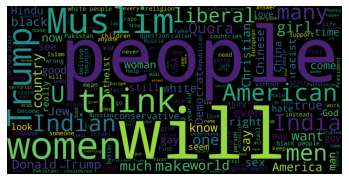

In [ ]:
wordcloud2 = WordCloud(stopwords=STOPWORDS, background_color='black', 
                      width=4000,height=2000).generate(spam_ques)

plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

In [ ]:
df['length']=[len(x) for x in df['question_text']]

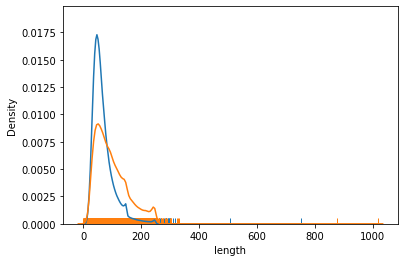

In [ ]:
sns.distplot(df.loc[df['target']==0,'length'], hist=False, rug=True);
sns.distplot(df.loc[df['target']==1,'length'], hist=False, rug=True);

In [ ]:
df['length'].max(), df['length'].min()

(1017, 1)

In [ ]:
df.isnull().sum()

qid              0
question_text    0
target           0
length           0
dtype: int64

In [ ]:
X = df['question_text'].values
y = df['target'].values

In [ ]:
X

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       ..., 'Is foam insulation toxic?',
       'How can one start a research project based on biochemistry at UG level?',
       'Who wins in a battle between a Wolverine and a Puma?'],
      dtype=object)

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X)
print(vocab_size)
# pad documents to a max length of 4 words
max_length = 20
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(len(padded_docs))

222162
1306122


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size=0.2, random_state=42)

In [ ]:
embeddings_index = dict()
f = open("/content/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(222162, 100)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
# define the model

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=20, trainable=False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           22216200  
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2001      
Total params: 22,218,201
Trainable params: 2,001
Non-trainable params: 22,216,200
_________________________________________________________________
None


In [ ]:
import keras
h = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=512,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Edvancer/Deep learning/Project 3 Spam filter for Quora questions/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Epoch 1/30
2041/2041 [==============================] - 23s 4ms/step - loss: 0.1946 - accuracy: 0.9299 - val_loss: 0.1502 - val_accuracy: 0.9449
Epoch 2/30
2041/2041 [==============================] - 8s 4ms/step - loss: 0.1512 - accuracy: 0.9438 - val_loss: 0.1492 - val_accuracy: 0.9448
Epoch 3/30
2041/2041 [==============================] - 9s 4ms/step - loss: 0.1493 - accuracy: 0.9446 - val_loss: 0.1476 - val_accuracy: 0.9458
Epoch 4/30
2041/2041 [==============================] - 10s 5ms/step - loss: 0.1489 - accuracy: 0.9445 - val_loss: 0.1474 - val_accuracy: 0.9458
Epoch 5/30
2041/2041 [==============================] - 8s 4ms/step - loss: 0.1489 - accuracy: 0.9444 - val_loss: 0.1465 - val_accuracy: 0.9458
Epoch 6/30
2041/2041 [==============================] - 9s 5ms/step - loss: 0.1484 - accuracy: 0.9444 - val_loss: 0.1471 - val_accuracy: 0.9456
Epoch 7/30
2041/2041 [==============================] - 8s 4ms/step - loss: 0.1478 - accuracy: 0.9447 - val_loss: 0.1462 - val_accurac

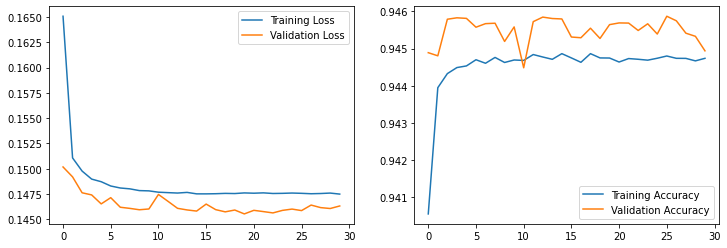

In [ ]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Edvancer/Deep learning/Project 3 Spam filter for Quora questions/model_0.9461.h5')
preds = model.predict_classes(X_test)

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %f' % (accuracy*100))

8164/8164 [==============================] - 11s 1ms/step - loss: 0.1458 - accuracy: 0.9461
Accuracy: 94.610393


In [ ]:
preds[preds==1]

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print(accuracy_score(y_test, preds))

[[242664   2705]
 [ 11374   4482]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    245369
           1       0.62      0.28      0.39     15856

    accuracy                           0.95    261225
   macro avg       0.79      0.64      0.68    261225
weighted avg       0.94      0.95      0.94    261225

0.946103933390755
